EDA

--- Running Preprocessing Pipeline ---
Column 'Product' processed.
Column 'Issue' processed.
Column 'Company' processed.
Column 'Submitted via' processed.
--- Preprocessing Complete ---


--- Starting Advanced EDA: Identifying Delay Drivers ---

--- Analyzing Feature: Product_preprocessed ---


C:\Users\timot\AppData\Local\Temp\ipykernel_22960\169070323.py:101: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y=risk_df.index, x=risk_df['risk_ratio'], palette='viridis')


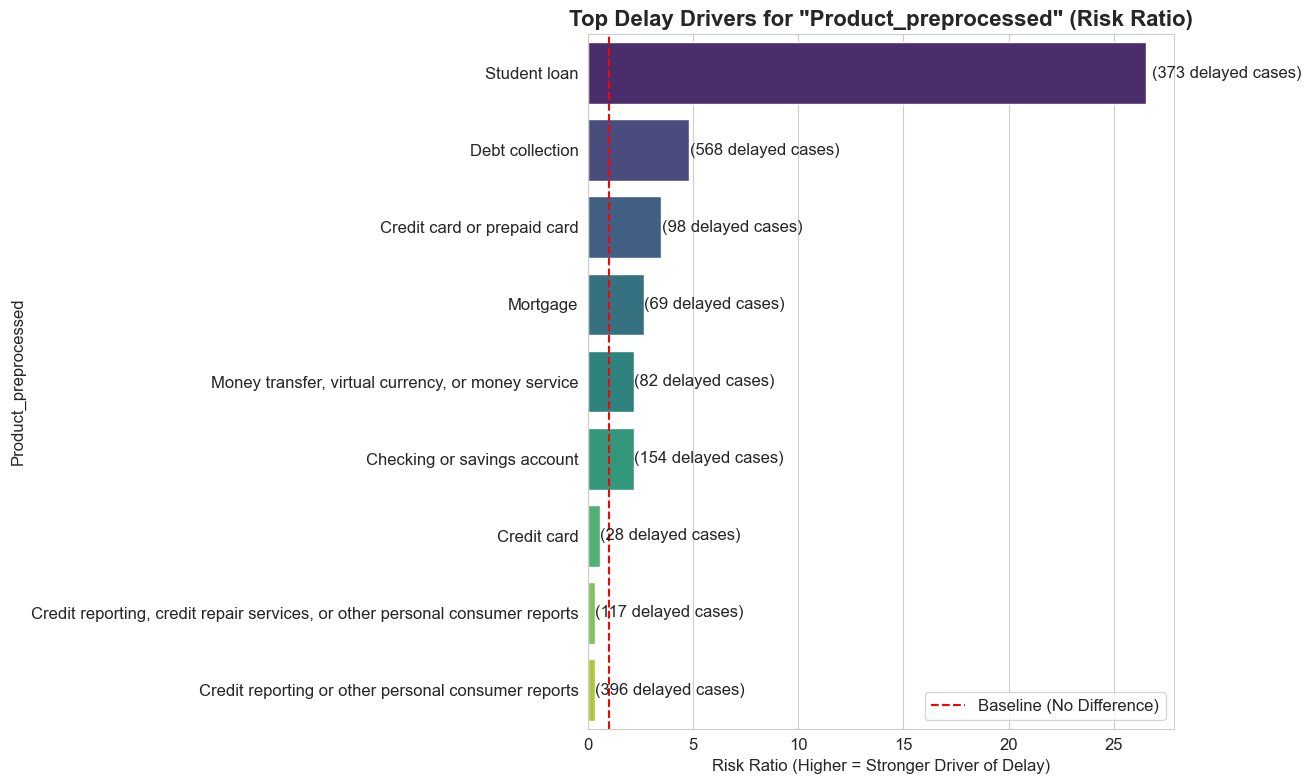


--- Analyzing Feature: Issue_preprocessed ---


C:\Users\timot\AppData\Local\Temp\ipykernel_22960\169070323.py:101: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y=risk_df.index, x=risk_df['risk_ratio'], palette='viridis')


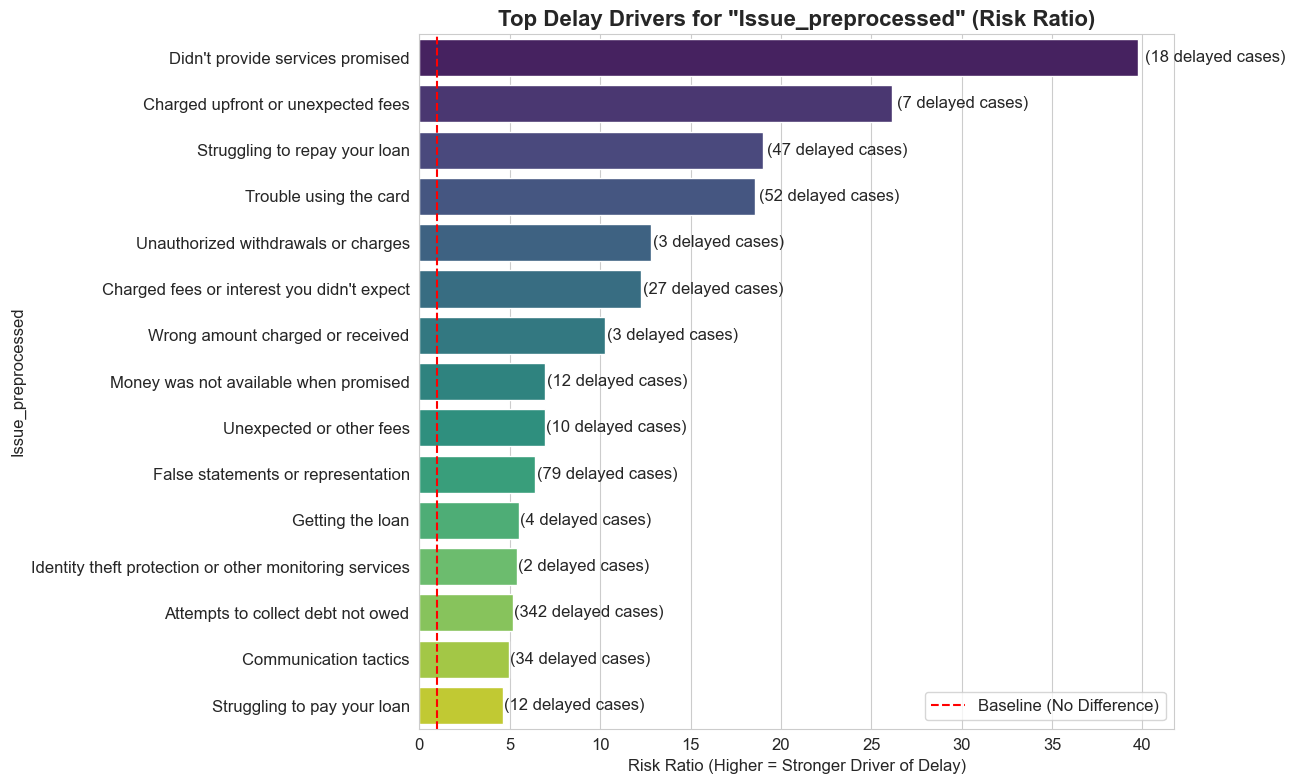


--- Analyzing Feature: Company_preprocessed ---


C:\Users\timot\AppData\Local\Temp\ipykernel_22960\169070323.py:101: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y=risk_df.index, x=risk_df['risk_ratio'], palette='viridis')


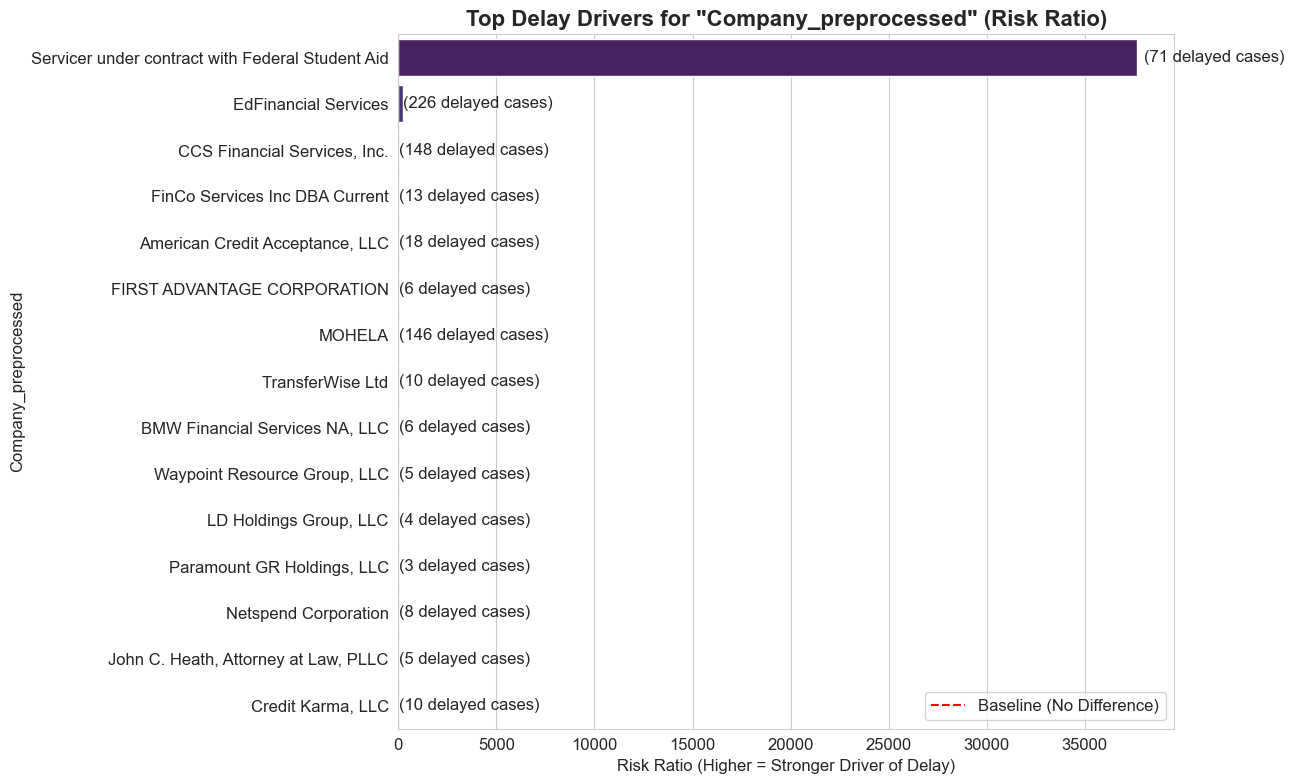


--- Analyzing Feature: Submitted via_preprocessed ---


C:\Users\timot\AppData\Local\Temp\ipykernel_22960\169070323.py:101: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y=risk_df.index, x=risk_df['risk_ratio'], palette='viridis')


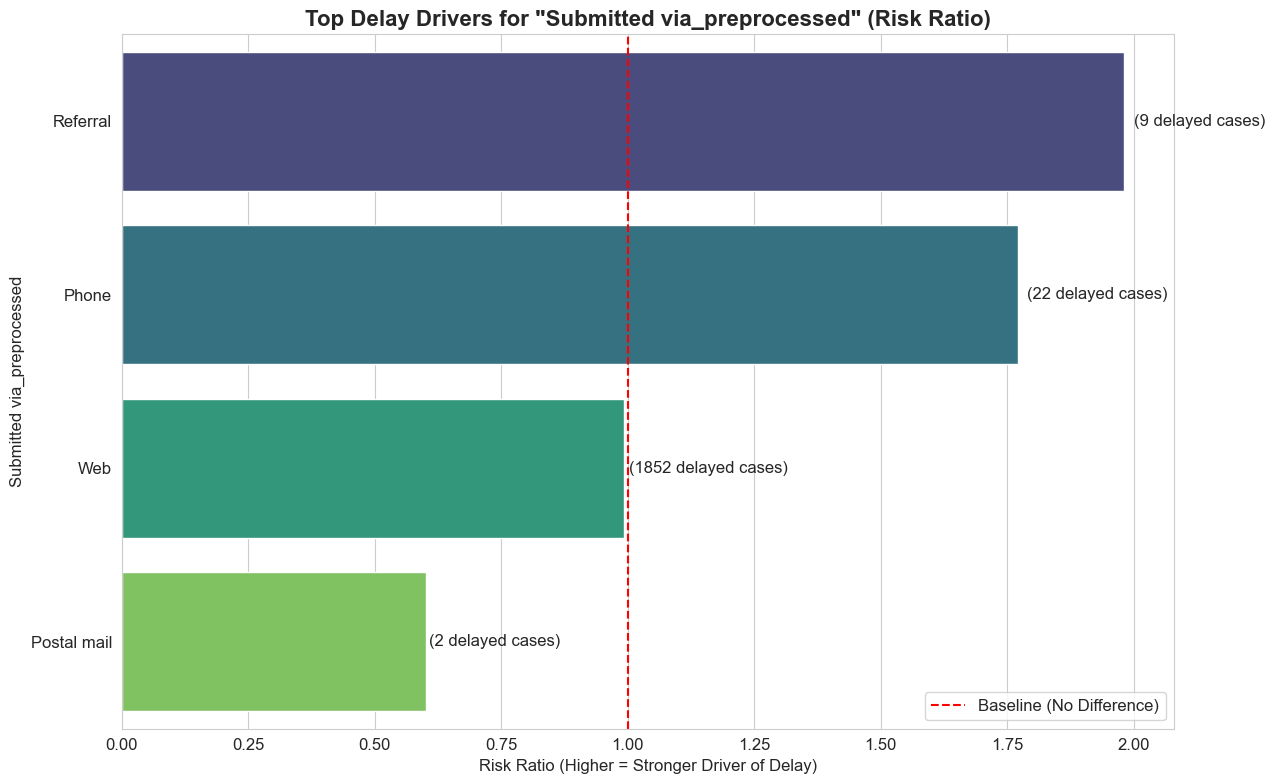

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rapidfuzz import process, fuzz
import numpy as np

# --- Configuration ---
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12

# --- Part 1: Data Preprocessing ---
def get_significant_anchors(series, min_freq_percent=0.01):
    if series.dropna().empty:
        return []
    counts = series.dropna().value_counts(normalize=True)
    significant_categories = counts[counts >= min_freq_percent]
    return significant_categories.index.tolist()

def preprocess_categories_fast(series, anchor_values, score_cutoff=80):
    unique_values = series.dropna().unique()
    correction_map = {}
    for value in unique_values:
        if not isinstance(value, str) or not anchor_values:
            continue
        best_match = process.extractOne(value, anchor_values, scorer=fuzz.WRatio, score_cutoff=score_cutoff)
        if best_match:
            correction_map[value] = best_match[0]
    return series.map(correction_map).fillna(series)

def run_preprocessing(df, columns_to_process):
    """Runs the full preprocessing pipeline and returns the processed DataFrame."""
    print("--- Running Preprocessing Pipeline ---")
    anchors_dict = {}
    FREQUENCY_THRESHOLD = 0.01

    for col in columns_to_process:
        anchors_dict[col] = get_significant_anchors(df[col], min_freq_percent=FREQUENCY_THRESHOLD)

    for col, anchors in anchors_dict.items():
        if not anchors:
            continue
        new_col_name = f"{col}_preprocessed"
        df[new_col_name] = preprocess_categories_fast(df[col], anchors, score_cutoff=80)
        print(f"Column '{col}' processed.")
    
    print("--- Preprocessing Complete ---\n")
    return df


# --- Part 2: Advanced EDA to Find Delay Drivers ---
def perform_lift_analysis_eda(df, features_to_analyze, min_samples=50):
    """
    Performs a comparative analysis to find features that are over-represented
    in delayed complaints.
    """
    print("\n--- Starting Advanced EDA: Identifying Delay Drivers ---")

    if 'Timely response?' not in df.columns:
        print("Error: Target variable 'Timely response?' not found.")
        return
        
    # Separate into delayed and timely groups
    df_delayed = df[df['Timely response?'] == 1]
    df_timely = df[df['Timely response?'] == 0]

    for feature in features_to_analyze:
        if feature not in df.columns:
            continue

        print(f"\n--- Analyzing Feature: {feature} ---")

        # Calculate proportions in each group
        prop_delayed = df_delayed[feature].value_counts(normalize=True)
        prop_timely = df_timely[feature].value_counts(normalize=True)
        
        # Combine into a single DataFrame for comparison
        risk_df = pd.DataFrame({
            'prop_delayed': prop_delayed,
            'prop_timely': prop_timely,
            'count_delayed': df_delayed[feature].value_counts(),
            'count_total': df[feature].value_counts()
        }).fillna(0)
        
        # Filter out categories with too few samples to be reliable
        risk_df = risk_df[risk_df['count_total'] > min_samples]
        
        # Calculate the Risk Ratio (Lift)
        # We add a small epsilon to avoid division by zero
        risk_df['risk_ratio'] = risk_df['prop_delayed'] / (risk_df['prop_timely'] + 1e-6)
        
        # Sort by the highest risk ratio and select top 15
        risk_df = risk_df.sort_values(by='risk_ratio', ascending=False).head(15)

        if risk_df.empty:
            print(f"No categories in '{feature}' met the minimum sample threshold of {min_samples}.")
            continue

        # --- Visualization ---
        plt.figure(figsize=(12, 8))
        ax = sns.barplot(y=risk_df.index, x=risk_df['risk_ratio'], palette='viridis')
        ax.axvline(1.0, color='r', linestyle='--', label='Baseline (No Difference)')
        plt.title(f'Top Delay Drivers for "{feature}" (Risk Ratio)', fontsize=16, fontweight='bold')
        plt.xlabel('Risk Ratio (Higher = Stronger Driver of Delay)', fontsize=12)
        plt.ylabel(feature, fontsize=12)
        plt.legend()
        plt.tight_layout()
        
        # Add annotations
        for i, (p, count) in enumerate(zip(ax.patches, risk_df['count_delayed'])):
            ax.text(p.get_width() * 1.01, p.get_y() + p.get_height() / 2,
                    f'({int(count)} delayed cases)',
                    va='center')
        
        plt.show()


# --- Main Execution ---
if __name__ == "__main__":
    file_path = "data.csv"
    df = pd.read_csv(file_path)

    # Basic cleaning
    df['Timely response?'] = df['Timely response?'].map({'Yes': 0, 'No': 1})

    # Define columns to process
    columns_to_process = ['Product', 'Issue', 'Company', 'Submitted via']
    
    # Run preprocessing
    df_processed = run_preprocessing(df.copy(), columns_to_process)
    
    # Define the processed columns to analyze
    processed_cols = [f"{col}_preprocessed" for col in columns_to_process]
    
    # Run the new, more insightful EDA
    # We set a minimum of 50 total complaints for a category to be considered
    perform_lift_analysis_eda(df_processed, processed_cols, min_samples=50)

In [2]:
# PEMUATAN & INSPEKSI DATA

# Ganti 'data - Copy.csv' dengan path file Anda jika perlu
file_path = 'data.csv'
df = pd.read_csv(file_path)

print("Dataset berhasil dimuat.")
print("\nInformasi Awal Dataset:")
df.info()

print("\nJumlah Nilai Kosong per Kolom:")
print(df.isnull().sum())

print("\n5 Baris Pertama Dataset:")
print(df.head())

Dataset berhasil dimuat.

Informasi Awal Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399046 entries, 0 to 399045
Data columns (total 18 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Date received                 399046 non-null  object 
 1   Product                       399046 non-null  object 
 2   Sub-product                   399045 non-null  object 
 3   Issue                         399045 non-null  object 
 4   Sub-issue                     385096 non-null  object 
 5   Consumer complaint narrative  239524 non-null  object 
 6   Company public response       226285 non-null  object 
 7   Company                       399046 non-null  object 
 8   State                         397871 non-null  object 
 9   ZIP code                      399040 non-null  object 
 10  Tags                          24390 non-null   object 
 11  Consumer consent provided?    381808 non-null  object 

MODELING

In [3]:
# INISIALISASI & SETUP

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings

# Library untuk pemrosesan dan pemodelan
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, precision_recall_curve, average_precision_score, confusion_matrix
from catboost import CatBoostClassifier

# Pengaturan
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
pd.options.display.max_colwidth = 150

print("Semua pustaka berhasil diimpor.")

Semua pustaka berhasil diimpor.


In [4]:
# PEMBERSIHAN DATA & PRA-PEMROSESAN

# --- 1. Membersihkan Nama Kolom ---
df.columns = df.columns.str.lower().str.replace('[^a-zA-Z0-9_]', '_', regex=True)

# --- 2. Mengatasi Nilai Kosong ---
df['consumer_complaint_narrative'].fillna('', inplace=True)

# --- 3. Konversi Tipe Data Tanggal ---
df['date_received'] = pd.to_datetime(df['date_received'], errors='coerce')
df['date_sent_to_company'] = pd.to_datetime(df['date_sent_to_company'], errors='coerce')
df.dropna(subset=['date_received', 'date_sent_to_company'], inplace=True) # Hapus baris jika tanggal tidak valid

In [5]:
# --- Normalisasi Entitas Perusahaan ---
from rapidfuzz import process, fuzz

unique_companies = df['company'].dropna().unique().tolist()
print(f"Jumlah nama perusahaan unik sebelum normalisasi: {len(unique_companies)}")

# Hapus sufiks umum dan ubah ke huruf besar
suffixes_to_remove = [' INC', ' LLC', ' INC.', ' L.L.C.', ' CORPORATION', ' BANK']
canonical_list = list(unique_companies)
for i, name in enumerate(canonical_list):
    for suffix in suffixes_to_remove:
        if name.upper().endswith(suffix):
            name = name[: -len(suffix)]
    canonical_list[i] = name.strip()
canonical_list = sorted(list(set(canonical_list)), key=len)

# Buat pemetaan dari nama asli ke nama kanonikal
mapping = {}
for company_name in unique_companies:
    best_match, score, _ = process.extractOne(company_name, canonical_list, scorer=fuzz.token_sort_ratio)
    if score > 85:
        mapping[company_name] = best_match
    else:
        mapping[company_name] = company_name # Jika tidak, gunakan nama asli

df['company_normalized'] = df['company'].map(mapping)

print(f"Jumlah nama perusahaan unik SETELAH normalisasi: {df['company_normalized'].nunique()}")

print("\nPembersihan data selesai.")
print("Contoh data setelah normalisasi berhasil:")
# Tampilkan beberapa contoh di mana normalisasi berhasil
successful_normalization = df[df['company'] != df['company_normalized']]
if not successful_normalization.empty:
    print(successful_normalization[['company', 'company_normalized']].head(10).drop_duplicates())
else:
    print("Tidak ada perubahan signifikan setelah normalisasi, mungkin perlu menurunkan threshold skor.")

Jumlah nama perusahaan unik sebelum normalisasi: 2346
Jumlah nama perusahaan unik SETELAH normalisasi: 2344

Pembersihan data selesai.
Contoh data setelah normalisasi berhasil:
                                  company                 company_normalized
0  TRANSUNION INTERMEDIATE HOLDINGS, INC.  TRANSUNION INTERMEDIATE HOLDINGS,
1     Experian Information Solutions Inc.     Experian Information Solutions
7              Convergent Resources, Inc.              Convergent Resources,


In [6]:
# FEATURE ENGINEERING

# --- 1. Membuat Variabel Target ---
df['is_delayed'] = (df['timely_response_'] == 'No').astype(int)

# --- 2. Fitur Berbasis Teks Sederhana ---
df['narrative_length'] = df['consumer_complaint_narrative'].str.len()
df['has_narrative'] = (df['narrative_length'] > 0).astype(int)

# --- 3. Fitur Berbasis Tanggal ---
df['day_of_week_received'] = df['date_received'].dt.dayofweek # Senin=0, Minggu=6
df['month_received'] = df['date_received'].dt.month

# --- 4. Menggabungkan Teks untuk Input Model ---
text_features_cols = ['product', 'sub_product', 'issue', 'sub_issue', 'consumer_complaint_narrative']
df[text_features_cols] = df[text_features_cols].fillna('')
df['combined_text'] = df[text_features_cols].apply(lambda x: ' '.join(x), axis=1)

print("Feature engineering selesai.")
print("\nDistribusi variabel target 'is_delayed':")
print(df['is_delayed'].value_counts(normalize=True))

print("\nContoh data dengan fitur baru:")
print(df[['combined_text', 'narrative_length', 'day_of_week_received', 'is_delayed']].head())

Feature engineering selesai.

Distribusi variabel target 'is_delayed':
is_delayed
0    0.995276
1    0.004724
Name: proportion, dtype: float64

Contoh data dengan fitur baru:
                                                                                                                                           combined_text  \
0  Credit reporting, credit repair services, or other personal consumer reports Credit reporting Improper use of your report Reporting company used y...   
1  Credit reporting, credit repair services, or other personal consumer reports Credit reporting Improper use of your report Credit inquiries on your...   
2  Credit reporting, credit repair services, or other personal consumer reports Credit reporting Problem with a credit reporting company's investigat...   
3  Credit reporting, credit repair services, or other personal consumer reports Credit reporting Improper use of your report Reporting company used y...   
4  Credit reporting, credit repair services, 

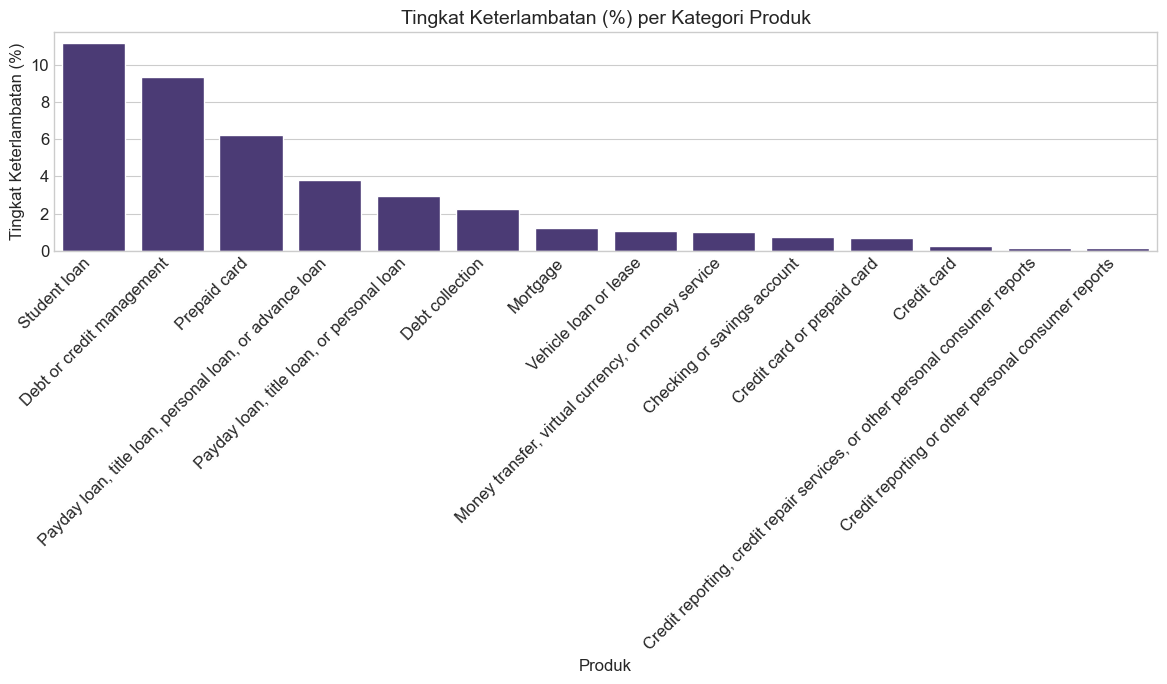

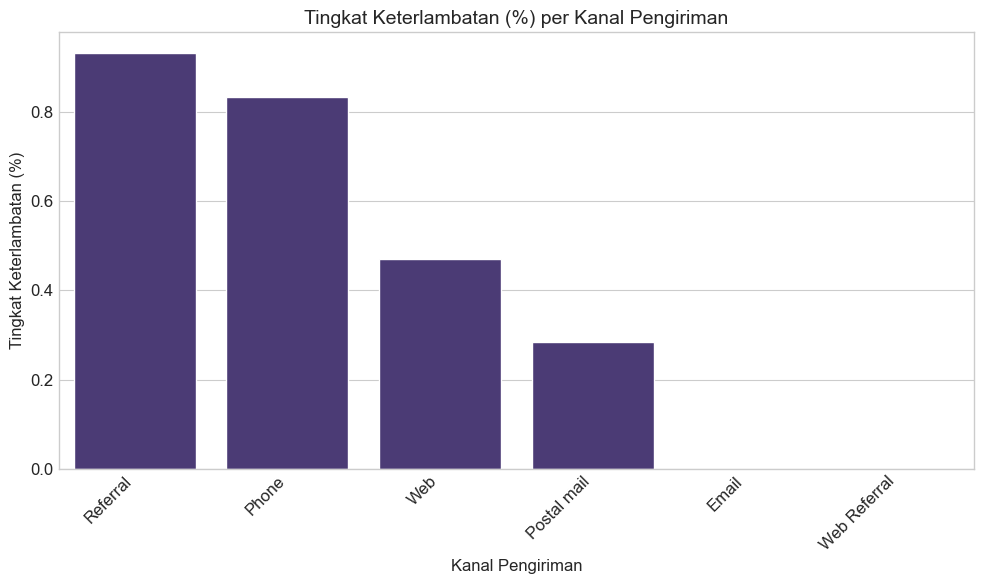

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

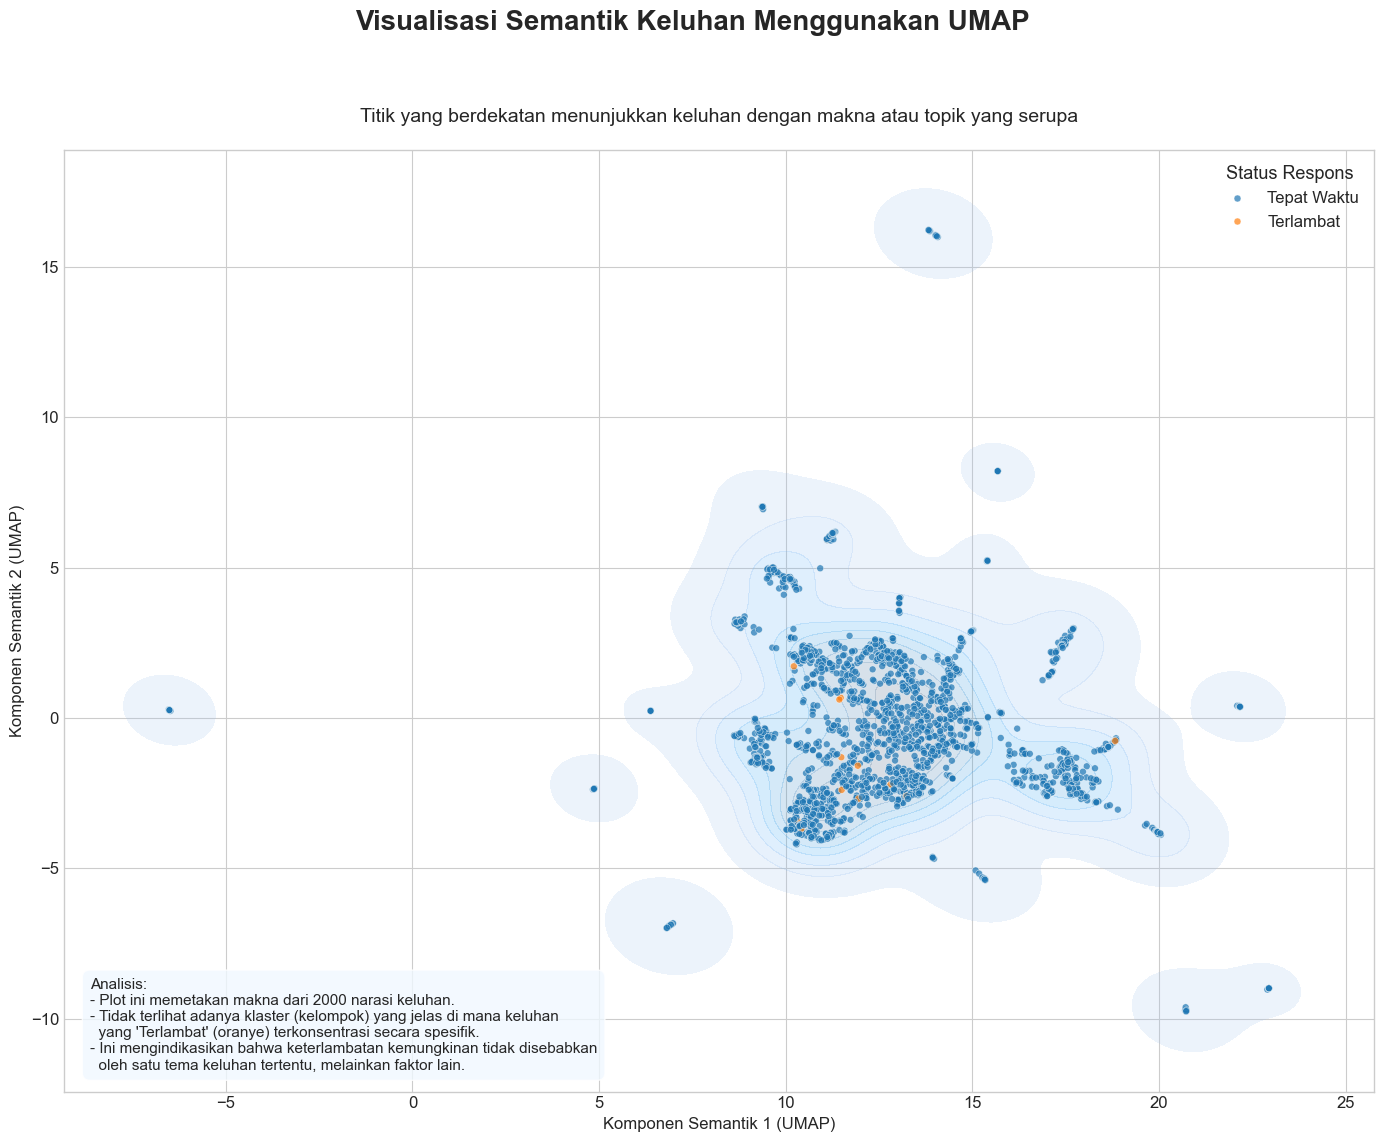

In [ ]:
# EXPLORATORY DATA ANALYSIS (EDA)

sns.set_palette("viridis")

# --- 1. Plot Tingkat Keterlambatan per Produk ---
plt.figure(figsize=(12, 7))
delay_rate_product = df.groupby('product')['is_delayed'].mean().sort_values(ascending=False) * 100
ax = sns.barplot(x=delay_rate_product.index, y=delay_rate_product.values)
plt.title('Tingkat Keterlambatan (%) per Kategori Produk', fontsize=14)
plt.ylabel('Tingkat Keterlambatan (%)')
plt.xlabel('Produk')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# --- 2. Plot Tingkat Keterlambatan per Kanal Pengiriman ---
plt.figure(figsize=(10, 6))
delay_rate_channel = df.groupby('submitted_via')['is_delayed'].mean().sort_values(ascending=False) * 100
ax = sns.barplot(x=delay_rate_channel.index, y=delay_rate_channel.values)
plt.title('Tingkat Keterlambatan (%) per Kanal Pengiriman', fontsize=14)
plt.ylabel('Tingkat Keterlambatan (%)')
plt.xlabel('Kanal Pengiriman')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# --- Visualisasi Semantik Teks (Scatter Text) ---
from sentence_transformers import SentenceTransformer
import umap.umap_ as umap
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Mengambil sampel data (sama seperti sebelumnya)
df_sample = df[df['has_narrative'] == 1].sample(2000, random_state=42)

# Membuat embeddings (sama seperti sebelumnya)
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(df_sample['consumer_complaint_narrative'].tolist(), show_progress_bar=True)

# Reduksi dimensi dengan UMAP (sama seperti sebelumnya)
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42, n_components=2)
embedding_2d = reducer.fit_transform(embeddings)

# Membuat DataFrame untuk plot
df_plot = pd.DataFrame(embedding_2d, columns=['x', 'y'])
# Memetakan nilai 0/1 ke label yang lebih deskriptif untuk legenda
df_plot['Status Respons'] = df_sample['is_delayed'].values
df_plot['Status Respons'] = df_plot['Status Respons'].map({0: 'Tepat Waktu', 1: 'Terlambat'})

# Inisialisasi plot
fig, ax = plt.subplots(figsize=(14, 12))

# Definisikan palet warna
palette = {'Tepat Waktu': '#1f77b4', 'Terlambat': '#ff7f0e'}

# 1. Gambar Kernel Density Estimate (KDE) plot untuk menunjukkan area konsentrasi
sns.kdeplot(
    data=df_plot, x='x', y='y', hue='Status Respons',
    fill=True, alpha=0.2, palette=palette, ax=ax,
    legend=False # Legenda akan dibuat dari scatter plot
)

# 2. Tumpuk dengan scatter plot untuk menunjukkan titik data individu
sns.scatterplot(
    data=df_plot, x='x', y='y', hue='Status Respons',
    palette=palette, s=25, alpha=0.7, ax=ax
)

# 3. Pengaturan Judul dan Label yang Informatif
fig.suptitle('Visualisasi Semantik Keluhan Menggunakan UMAP', fontsize=20, fontweight='bold')
ax.set_title('Titik yang berdekatan menunjukkan keluhan dengan makna atau topik yang serupa', fontsize=14, pad=20)
ax.set_xlabel('Komponen Semantik 1 (UMAP)', fontsize=12)
ax.set_ylabel('Komponen Semantik 2 (UMAP)', fontsize=12)

# 4. Tambahkan Anotasi Penjelasan
explanation_text = (
    "Analisis:\n"
    "- Plot ini memetakan makna dari 2000 narasi keluhan.\n"
    "- Tidak terlihat adanya klaster (kelompok) yang jelas di mana keluhan\n"
    "  yang 'Terlambat' (oranye) terkonsentrasi secara spesifik.\n"
    "- Ini mengindikasikan bahwa keterlambatan kemungkinan tidak disebabkan\n"
    "  oleh satu tema keluhan tertentu, melainkan faktor lain."
)
ax.text(0.02, 0.02, explanation_text, transform=ax.transAxes, fontsize=11,
        verticalalignment='bottom', bbox=dict(boxstyle='round,pad=0.5', fc='aliceblue', alpha=0.8))

# 5. Perbaiki Legenda
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title='Status Respons', fontsize=12, title_fontsize=13)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

--- Memulai Pelatihan Model 1: CatBoost ---
0:	learn: 0.6284047	total: 173ms	remaining: 1m 26s
100:	learn: 0.1419051	total: 8.75s	remaining: 34.6s
200:	learn: 0.1230489	total: 17.2s	remaining: 25.6s
300:	learn: 0.1079062	total: 25.8s	remaining: 17.1s
400:	learn: 0.0958641	total: 34.2s	remaining: 8.44s
499:	learn: 0.0865232	total: 42.4s	remaining: 0us
Model training CatBoost selesai.

--- Memulai Pelatihan Model 2: LightGBM ---
Model training LightGBM selesai.

--- Memulai Pelatihan Model 3: XGBoost ---
Model training XGBoost selesai.


HASIL EVALUASI & PERBANDINGAN MODEL


--- Laporan Klasifikasi (CatBoost) ---
                 precision    recall  f1-score   support

Tepat Waktu (0)       1.00      0.97      0.98     99291
  Terlambat (1)       0.12      0.84      0.21       471

       accuracy                           0.97     99762
      macro avg       0.56      0.91      0.60     99762
   weighted avg       1.00      0.97      0.98     99762


--- Laporan Klasifikasi (LightGBM) 

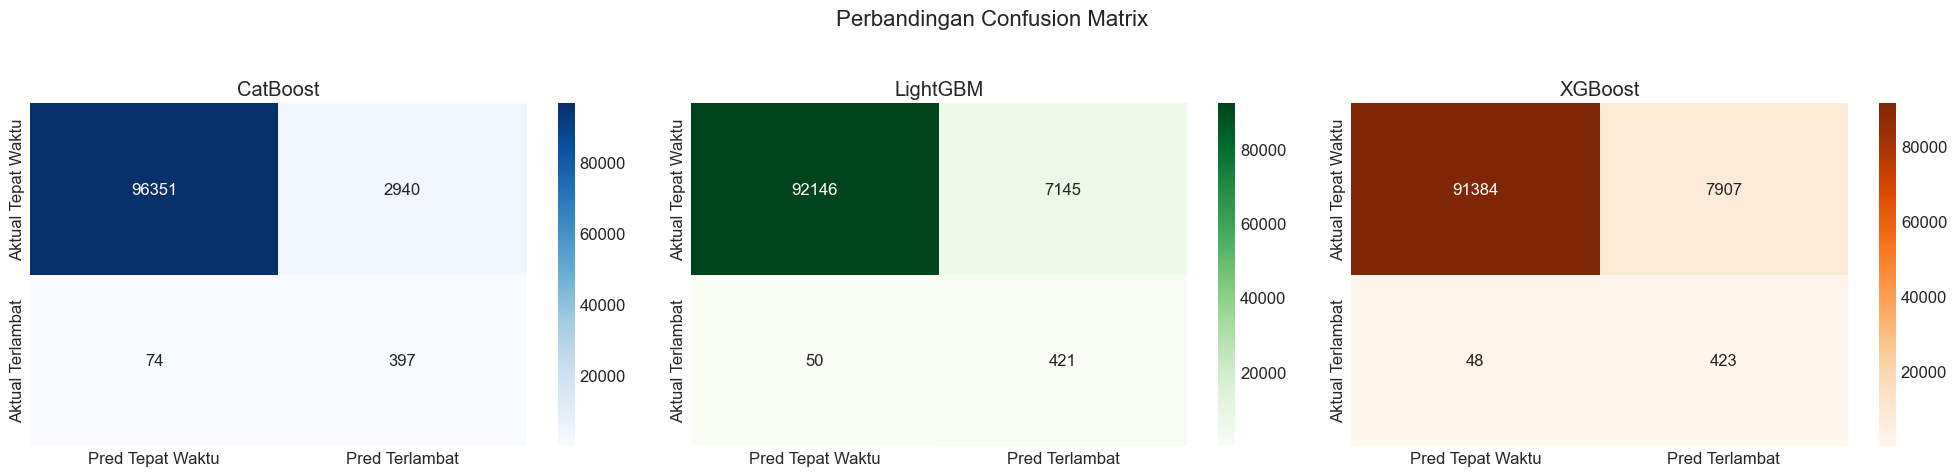

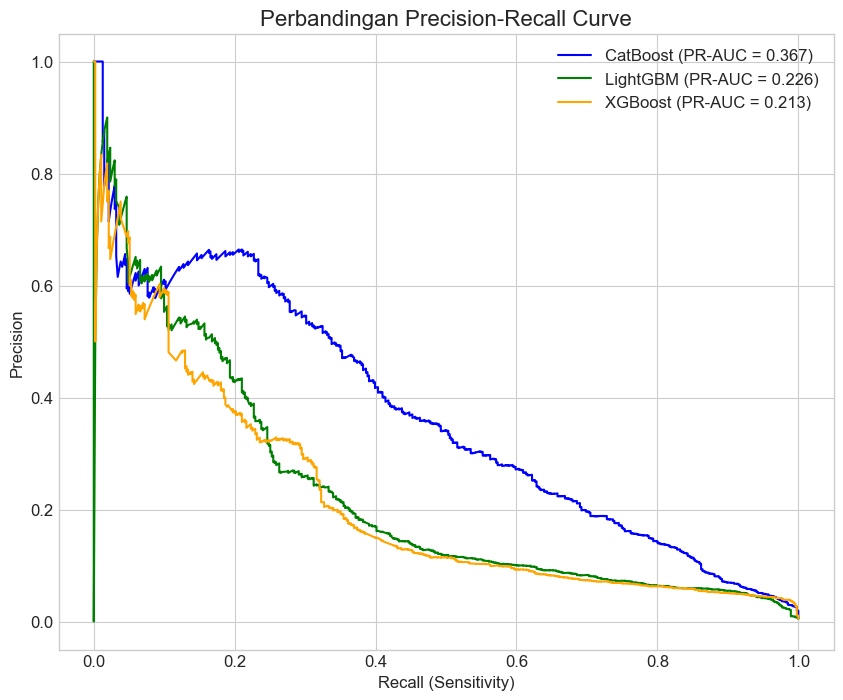


Variabel `model_pipeline`, `y_pred`, dan `y_pred_proba` sekarang berisi hasil dari model CatBoost.
Sel berikutnya untuk analisis SHAP dan ekspor akan menggunakan hasil CatBoost.


In [ ]:
# PEMODELAN & EVALUASI KOMPARATIF: CatBoost vs. LightGBM vs. XGBoost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score
from catboost import CatBoostClassifier
import lightgbm as lgb
from xgboost import XGBClassifier

# --- 1. PERSIAPAN DATA ---

# Menggunakan DataFrame 'df' yang sudah diproses dari sel sebelumnya
# Memastikan tipe data kategorikal
for col in ['product', 'submitted_via', 'company_normalized']:
    df[col] = df[col].astype('category')

X = df.drop('is_delayed', axis=1)
y = df['is_delayed']

# Definisi fitur
text_feature = 'combined_text'
numerical_features = ['narrative_length', 'day_of_week_received', 'has_narrative']
categorical_features = ['product', 'submitted_via', 'company_normalized']

# Split data (stratified)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Hitung bobot kelas untuk model yang membutuhkannya (LGBM & XGBoost)
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

# Siapkan data frame untuk pipeline
X_train_for_pipeline = X_train[[text_feature] + numerical_features + categorical_features]
X_test_for_pipeline = X_test[[text_feature] + numerical_features + categorical_features]

# --- Dictionary untuk menyimpan hasil ---
results = {}

# --- 2. MODEL 1: CATBOOST (MODEL UTAMA) ---
print("--- Memulai Pelatihan Model 1: CatBoost ---")
# Preprocessor khusus untuk CatBoost yang menangani kategori secara internal
preprocessor_catboost = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(stop_words='english', max_features=2500, ngram_range=(1,2)), text_feature),
        ('num', StandardScaler(), numerical_features),
    ],
    remainder='drop'
)
preprocessor_base_catboost = Pipeline(steps=[('preprocessor', preprocessor_catboost)])
preprocessor_final_catboost = ColumnTransformer(
    transformers=[
        ('processed', preprocessor_base_catboost, [text_feature] + numerical_features),
        ('categorical', 'passthrough', categorical_features)
    ],
    sparse_threshold=0
)
num_text_features_count = 2500 + len(numerical_features)
categorical_feature_indices = list(range(num_text_features_count, num_text_features_count + len(categorical_features)))

model_pipeline_catboost = Pipeline(steps=[
    ('preprocessor', preprocessor_final_catboost),
    ('classifier', CatBoostClassifier(
        iterations=500, learning_rate=0.05, depth=6, auto_class_weights='Balanced',
        random_state=42, verbose=100, cat_features=categorical_feature_indices, task_type="GPU"
    ))
])

model_pipeline_catboost.fit(X_train_for_pipeline, y_train)
y_pred_catboost = model_pipeline_catboost.predict(X_test_for_pipeline)
y_pred_proba_catboost = model_pipeline_catboost.predict_proba(X_test_for_pipeline)[:, 1]
print("Model training CatBoost selesai.\n")

# Simpan hasil
results['CatBoost'] = {
    'report': classification_report(y_test, y_pred_catboost, target_names=['Tepat Waktu (0)', 'Terlambat (1)']),
    'cm': confusion_matrix(y_test, y_pred_catboost),
    'precision_recall': precision_recall_curve(y_test, y_pred_proba_catboost),
    'pr_auc': average_precision_score(y_test, y_pred_proba_catboost)
}

# --- 3. MODEL 2: LIGHTGBM (MODEL PEMBANDING) ---
print("--- Memulai Pelatihan Model 2: LightGBM ---")
# Preprocessor untuk LGBM & XGBoost yang menggunakan OneHotEncoder
preprocessor_ohe = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(stop_words='english', max_features=2500, ngram_range=(1, 2)), text_feature),
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='drop'
)

model_pipeline_lgbm = Pipeline(steps=[
    ('preprocessor', preprocessor_ohe),
    ('classifier', lgb.LGBMClassifier(
        n_estimators=500, learning_rate=0.05, max_depth=6, scale_pos_weight=scale_pos_weight,
        random_state=42, verbose=-1, device="gpu"
    ))
])

model_pipeline_lgbm.fit(X_train_for_pipeline, y_train)
y_pred_lgbm = model_pipeline_lgbm.predict(X_test_for_pipeline)
y_pred_proba_lgbm = model_pipeline_lgbm.predict_proba(X_test_for_pipeline)[:, 1]
print("Model training LightGBM selesai.\n")

# Simpan hasil
results['LightGBM'] = {
    'report': classification_report(y_test, y_pred_lgbm, target_names=['Tepat Waktu (0)', 'Terlambat (1)']),
    'cm': confusion_matrix(y_test, y_pred_lgbm),
    'precision_recall': precision_recall_curve(y_test, y_pred_proba_lgbm),
    'pr_auc': average_precision_score(y_test, y_pred_proba_lgbm)
}


# --- 4. MODEL 3: XGBOOST (MODEL PEMBANDING) ---
print("--- Memulai Pelatihan Model 3: XGBoost ---")
model_pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor_ohe),
    ('classifier', XGBClassifier(
        n_estimators=500, learning_rate=0.05, max_depth=6, scale_pos_weight=scale_pos_weight,
        random_state=42, tree_method='gpu_hist', device='cuda',
        eval_metric='logloss', use_label_encoder=False
    ))
])

model_pipeline_xgb.fit(X_train_for_pipeline, y_train)
y_pred_xgb = model_pipeline_xgb.predict(X_test_for_pipeline)
y_pred_proba_xgb = model_pipeline_xgb.predict_proba(X_test_for_pipeline)[:, 1]
print("Model training XGBoost selesai.\n")

# Simpan hasil
results['XGBoost'] = {
    'report': classification_report(y_test, y_pred_xgb, target_names=['Tepat Waktu (0)', 'Terlambat (1)']),
    'cm': confusion_matrix(y_test, y_pred_xgb),
    'precision_recall': precision_recall_curve(y_test, y_pred_proba_xgb),
    'pr_auc': average_precision_score(y_test, y_pred_proba_xgb)
}


# --- 5. VISUALISASI PERBANDINGAN HASIL ---
print("\n" + "="*50)
print("HASIL EVALUASI & PERBANDINGAN MODEL")
print("="*50 + "\n")

# Tampilkan Laporan Klasifikasi
for model_name, result in results.items():
    print(f"\n--- Laporan Klasifikasi ({model_name}) ---")
    print(result['report'])

# Tampilkan Confusion Matrices secara berdampingan
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Perbandingan Confusion Matrix', fontsize=16)

sns.heatmap(results['CatBoost']['cm'], annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Pred Tepat Waktu', 'Pred Terlambat'], yticklabels=['Aktual Tepat Waktu', 'Aktual Terlambat'])
axes[0].set_title('CatBoost')

sns.heatmap(results['LightGBM']['cm'], annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['Pred Tepat Waktu', 'Pred Terlambat'], yticklabels=['Aktual Tepat Waktu', 'Aktual Terlambat'])
axes[1].set_title('LightGBM')

sns.heatmap(results['XGBoost']['cm'], annot=True, fmt='d', cmap='Oranges', ax=axes[2],
            xticklabels=['Pred Tepat Waktu', 'Pred Terlambat'], yticklabels=['Aktual Tepat Waktu', 'Aktual Terlambat'])
axes[2].set_title('XGBoost')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Tampilkan Kurva Precision-Recall dalam satu plot
plt.figure(figsize=(10, 8))
colors = {'CatBoost': 'blue', 'LightGBM': 'green', 'XGBoost': 'orange'}

for model_name, result in results.items():
    precision, recall, _ = result['precision_recall']
    pr_auc = result['pr_auc']
    plt.plot(recall, precision, label=f'{model_name} (PR-AUC = {pr_auc:.3f})', color=colors[model_name])

plt.title('Perbandingan Precision-Recall Curve', fontsize=16)
plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()

# --- 6. MENYIAPKAN VARIABEL FINAL (DARI CATBOOST) UNTUK SEL BERIKUTNYA ---
model_pipeline = model_pipeline_catboost
y_pred = y_pred_catboost
y_pred_proba = y_pred_proba_catboost

print("\nVariabel `model_pipeline`, `y_pred`, dan `y_pred_proba` sekarang berisi hasil dari model CatBoost.")
print("Sel berikutnya untuk analisis SHAP dan ekspor akan menggunakan hasil CatBoost.")


--- SHAP Summary Plot (CatBoost) ---


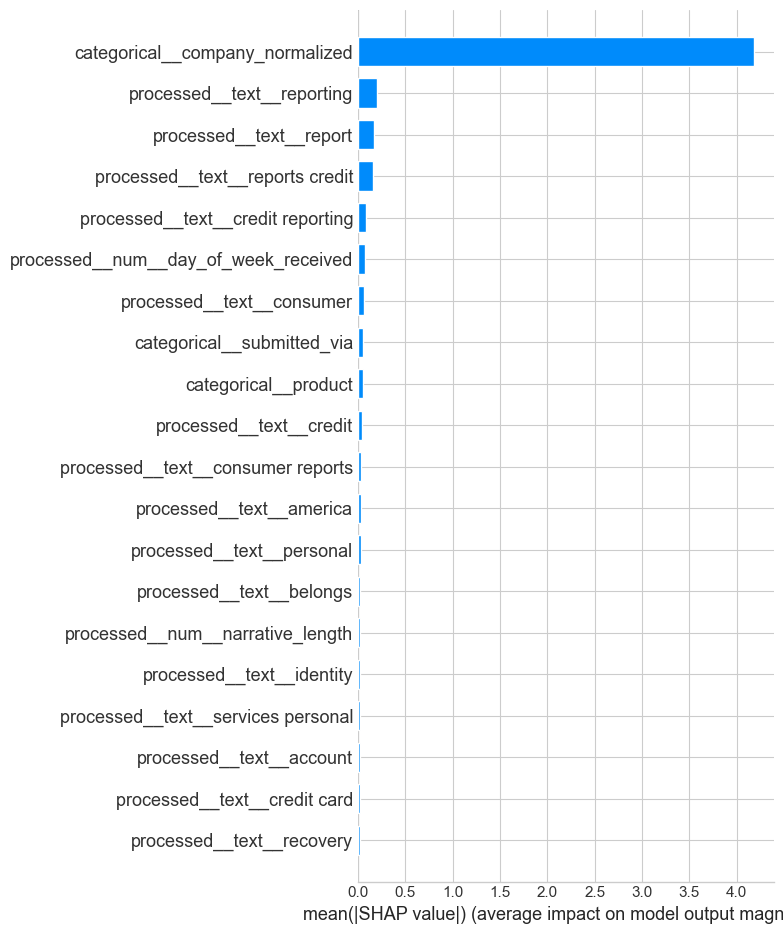

Analisis SHAP siap dijalankan di lingkungan Anda untuk mengungkap faktor pendorong prediksi.


In [9]:
# INTERPRETASI MODEL
import shap

# Ekstrak komponen dari pipeline
preprocessor = model_pipeline.named_steps['preprocessor']
classifier = model_pipeline.named_steps['classifier']

# Transformasi data uji. Pastikan formatnya adalah array dense untuk TreeExplainer.
X_test_transformed = preprocessor.transform(X_test)
if hasattr(X_test_transformed, "toarray"): # Cek jika outputnya sparse matrix
    X_test_transformed = X_test_transformed.toarray()

# Gunakan TreeExplainer untuk model berbasis tree seperti CatBoost
explainer = shap.TreeExplainer(classifier)
shap_values = explainer.shap_values(X_test_transformed)

# Dapatkan semua nama fitur langsung dari preprocessor
all_feature_names = preprocessor.get_feature_names_out()
# Konversi ke DataFrame untuk SHAP (memastikan kompatibilitas)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=all_feature_names)


# Visualisasi SHAP Summary Plot
print("\n--- SHAP Summary Plot (CatBoost) ---")
shap.summary_plot(shap_values, X_test_transformed_df, max_display=20, plot_type="bar")
print("Analisis SHAP siap dijalankan di lingkungan Anda untuk mengungkap faktor pendorong prediksi.")

In [10]:
# --- Ekstrak Top Risk Factors untuk Setiap Keluhan ---

print("Memulai ekstraksi Top 3 Risk Factors per keluhan dari hasil SHAP...")
abs_shap_values = np.abs(shap_values)

top_factors_list = []

# Loop melalui setiap baris data di set tes
for i in range(len(X_test)):
    # Dapatkan indeks dari 3 fitur dengan SHAP value absolut tertinggi
    top_indices = np.argsort(abs_shap_values[i])[::-1][:3]
    
    # Ambil nama fitur dari indeks tersebut
    top_features = [all_feature_names[j] for j in top_indices]
    
    # Gabungkan menjadi satu string, dipisahkan koma
    top_factors_string = ', '.join(top_features)
    
    # Tambahkan ke list
    top_factors_list.append(top_factors_string)

print(f"Ekstraksi selesai. Berhasil mendapatkan top factors untuk {len(top_factors_list)} keluhan.")
print("\nContoh Top Factors untuk 5 keluhan pertama:")
for i in range(5):
    print(f"Keluhan {i+1}: {top_factors_list[i]}")

Memulai ekstraksi Top 3 Risk Factors per keluhan dari hasil SHAP...
Ekstraksi selesai. Berhasil mendapatkan top factors untuk 99762 keluhan.

Contoh Top Factors untuk 5 keluhan pertama:
Keluhan 1: categorical__company_normalized, processed__text__reporting, processed__text__reports credit
Keluhan 2: categorical__company_normalized, processed__text__services personal, processed__text__credit reporting
Keluhan 3: categorical__company_normalized, processed__text__report, processed__text__reporting
Keluhan 4: categorical__company_normalized, categorical__submitted_via, processed__text__reporting credit
Keluhan 5: categorical__company_normalized, processed__text__reports credit, processed__text__written


In [11]:

# ANALISIS MENDALAM (GOLDEN INSIGHT DENGAN BERTOPIC)


from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

high_risk_indices = np.where(y_pred == 1)[0]
high_risk_narratives = X_test.iloc[high_risk_indices]['consumer_complaint_narrative'].tolist()
high_risk_narratives = [narr for narr in high_risk_narratives if len(narr.split()) > 10] # Filter narasi pendek

if len(high_risk_narratives) > 10:
    embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
    topic_model = BERTopic(embedding_model=embedding_model, verbose=True, min_topic_size=5)

    topics, _ = topic_model.fit_transform(high_risk_narratives)
    print("\n--- Tema Utama dalam Keluhan Berisiko Tinggi ---")
    print(topic_model.get_topic_info())
else:
    print("Tidak cukup data keluhan berisiko tinggi untuk melakukan topic modeling.")
print("Analisis BERTopic siap dijalankan untuk menemukan 'isu di dalam isu' pada keluhan berisiko.")

2025-08-21 23:21:50,537 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/75 [00:00<?, ?it/s]

2025-08-21 23:22:02,272 - BERTopic - Embedding - Completed ✓
2025-08-21 23:22:02,272 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-08-21 23:22:14,061 - BERTopic - Dimensionality - Completed ✓
2025-08-21 23:22:14,063 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-08-21 23:22:14,193 - BERTopic - Cluster - Completed ✓
2025-08-21 23:22:14,201 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-08-21 23:22:14,642 - BERTopic - Representation - Completed ✓



--- Tema Utama dalam Keluhan Berisiko Tinggi ---
    Topic  Count                                          Name  \
0      -1    839                            -1_xxxx_the_and_to   
1       0    350                    0_bank_america_account_the   
2       1     70                     1_card_gift_vanilla_cards   
3       2     69                    2_loan_00_payment_interest   
4       3     51                   3_edfinancial_loans_loan_on   
..    ...    ...                                           ...   
64     63      6                63_greensky_llc_reporting_llcs   
65     64      6  64_account_fraudulent_collection_collections   
66     65      6     65_concerning_attention_doubts_validation   
67     66      5        66_lender_security_property_collateral   
68     67      5         67_national_management_letters_harris   

                                                                                        Representation  \
0                                                  

In [12]:

# BAGIAN 8: DARI MODEL KE PRODUK (LOGIKA DASHBOARD)

def create_dashboard_output(new_ticket_df, model):
    """
    Mengambil data tiket baru dan model terlatih, lalu menghasilkan
    output terstruktur untuk ditampilkan di dashboard.
    """
    # 1. Prediksi Risiko
    risk_probability = model.predict_proba(new_ticket_df)[0][1]

    # 2. Tentukan Level Prioritas
    if risk_probability > 0.6:
        priority_level = "Tinggi"
    elif risk_probability > 0.2:
        priority_level = "Sedang"
    else:
        priority_level = "Rendah"

    # 3. Hitung Severity Score
    channel = new_ticket_df['submitted_via'].iloc[0]
    has_narr = new_ticket_df['has_narrative'].iloc[0]
    
    channel_weight = 1.0 if channel in ['Postal mail', 'Referral'] else 0.2
    narrative_weight = 1.0 if has_narr == 1 else 0.0
    
    severity_score = (risk_probability * 70) + (channel_weight * 20) + (narrative_weight * 10)

    # Dapatkan Alasan Utama
    top_risk_factors = "Analisis SHAP diperlukan untuk detail per tiket"
    
    # 5. Berikan Rekomendasi
    if priority_level == "Tinggi":
        recommendation = "Eskalasikan ke agen senior; target respons < 24 jam."
    elif priority_level == "Sedang":
        recommendation = "Tangani dalam 3 hari kerja (SLA standar)."
    else:
        recommendation = "Proses dalam antrian reguler."
        
    # Gabungkan semua dalam satu output
    dashboard_data = {
    'complaint_id': int(new_ticket_df['complaint_id'].iloc[0]),
    'risk_probability_percent': f"{risk_probability:.2%}",
    'priority_level': priority_level,
    'severity_score': float(round(severity_score, 2)),         
    'top_risk_factors': top_risk_factors,
    'recommended_action': recommendation
    }
    
    return dashboard_data

# --- Simulasi tiket baru ---
sample_ticket = X_test.sample(1, random_state=42)
dashboard_result = create_dashboard_output(sample_ticket, model_pipeline)

print("\n--- Contoh Output untuk Dashboard ---")
import json
print(json.dumps(dashboard_result, indent=2))


--- Contoh Output untuk Dashboard ---
{
  "complaint_id": 12631926,
  "risk_probability_percent": "0.21%",
  "priority_level": "Rendah",
  "severity_score": 14.14,
  "top_risk_factors": "Analisis SHAP diperlukan untuk detail per tiket",
  "recommended_action": "Proses dalam antrian reguler."
}


In [13]:
# --- BAGIAN 9: EKSPOR HASIL PREDIKSI UNTUK DASHBOARD ---

print("Memulai proses ekspor hasil prediksi untuk dashboard...")

# DataFrame output berdasarkan data tes
output_df = X_test[['complaint_id', 'submitted_via', 'has_narrative']].copy()

# probabilitas risiko dari model
output_df['risk_probability_percent'] = y_pred_proba

priorities = []
severities = []
recommendations = []

# Loop melalui setiap prediksi untuk menerapkan logika dari Bagian 8
for idx, row in output_df.iterrows():
    prob = row['risk_probability_percent']
    
    # Logika Priority Level
    if prob > 0.6:
        priority = "Tinggi"
        recommendation = "Eskalasikan ke agen senior; target respons < 24 jam."
    elif prob > 0.2:
        priority = "Sedang"
        recommendation = "Tangani dalam 3 hari kerja (SLA standar)."
    else:
        priority = "Rendah"
        recommendation = "Proses dalam antrian reguler."
    
    # Logika Severity Score
    channel_weight = 1.0 if row['submitted_via'] in ['Postal mail', 'Referral'] else 0.2
    narrative_weight = 1.0 if row['has_narrative'] == 1 else 0.0
    severity = (prob * 70) + (channel_weight * 20) + (narrative_weight * 10)
    
    priorities.append(priority)
    severities.append(round(severity, 2))
    recommendations.append(recommendation)

output_df['priority_level'] = priorities
output_df['severity_score'] = severities
output_df['recommended_action'] = recommendations

output_df['top_risk_factors'] = top_factors_list

# Tambahkan label aktual untuk perbandingan di dashboard
output_df = output_df.merge(y_test.rename('is_delayed_actual'), left_index=True, right_index=True)

# Ubah nama kolom agar konsisten untuk proses join nanti
output_df.rename(columns={'complaint_id': 'Complaint ID'}, inplace=True)

# Pilih dan urutkan kolom sesuai skema 'Golden Dataset'
final_columns = [
    'Complaint ID',
    'risk_probability_percent',
    'priority_level',
    'severity_score',
    'top_risk_factors',
    'recommended_action',
    'is_delayed_actual'
]
final_output_df = output_df[final_columns]

# Simpan ke CSV
output_filename_model = 'model_prediction_output.csv'
final_output_df.to_csv(output_filename_model, index=False)

print(f"\n--- Hasil Prediksi Model Berhasil Disimpan ---")
print(f"File disimpan sebagai: {output_filename_model}")
print("File ini berisi 'Complaint ID' dan semua output prediksi & kalkulasi.")
print("\nContoh 5 baris pertama dari file output:")
print(final_output_df.head())

Memulai proses ekspor hasil prediksi untuk dashboard...

--- Hasil Prediksi Model Berhasil Disimpan ---
File disimpan sebagai: model_prediction_output.csv
File ini berisi 'Complaint ID' dan semua output prediksi & kalkulasi.

Contoh 5 baris pertama dari file output:
        Complaint ID  risk_probability_percent priority_level  severity_score  \
27094        6693366                  0.001308         Rendah           14.09   
74492        7238141                  0.000513         Rendah            4.04   
206635       9142159                  0.001417         Rendah           14.10   
48617        6943122                  0.117335         Rendah           12.21   
351409      12361973                  0.001950         Rendah           14.14   

                                                                                              top_risk_factors  \
27094             categorical__company_normalized, processed__text__reporting, processed__text__reports credit   
74492   categorica

--- Rasio Keterlambatan Berdasarkan Keberadaan Narasi ---
Tanpa Narasi (has_narrative=0)     0.25%
Dengan Narasi (has_narrative=1)    0.62%
Name: is_delayed, dtype: object




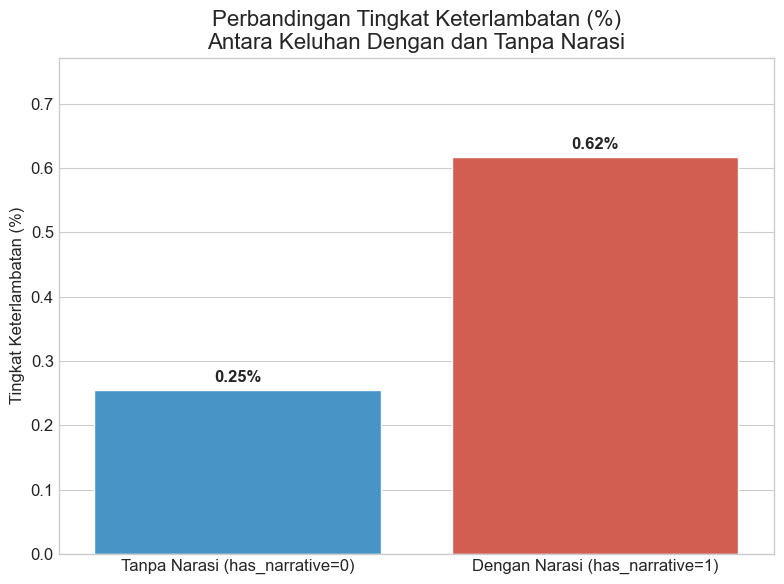

In [14]:
# --- RASIO KETERLAMBATAN DENGAN vs TANPA NARASI

# 1. Hitung rasio keterlambatan untuk setiap grup
delay_ratio_by_narrative = df.groupby('has_narrative')['is_delayed'].mean() * 100

# Ubah nama indeks agar lebih deskriptif untuk plot
delay_ratio_by_narrative.index = ['Tanpa Narasi (has_narrative=0)', 'Dengan Narasi (has_narrative=1)']

# 2. Tampilkan hasil perhitungan dalam bentuk teks
print("--- Rasio Keterlambatan Berdasarkan Keberadaan Narasi ---")
print(delay_ratio_by_narrative.round(2).astype(str) + '%')
print("\n")

# 3. Buat visualisasi menggunakan bar plot untuk perbandingan yang jelas
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=delay_ratio_by_narrative.index, y=delay_ratio_by_narrative.values, palette=['#3498db', '#e74c3c'])

# Menambahkan label persentase di atas setiap bar untuk kemudahan membaca
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 9), 
                textcoords='offset points',
                fontsize=12,
                fontweight='bold')

# Pengaturan judul dan label plot
plt.title('Perbandingan Tingkat Keterlambatan (%)\nAntara Keluhan Dengan dan Tanpa Narasi', fontsize=16)
plt.ylabel('Tingkat Keterlambatan (%)', fontsize=12)
plt.xlabel('')
plt.ylim(0, delay_ratio_by_narrative.max() * 1.25) # Memberi ruang di atas bar
plt.xticks(fontsize=12)
plt.tight_layout()
plt.show()

### TEXT ANALYSIS

In [ ]:
import pandas as pd
from flair.models import TextClassifier
from flair.data import Sentence
from sentence_transformers import SentenceTransformer, util
from bertopic import BERTopic
from hdbscan import HDBSCAN
import torch
import numpy as np

# --- Konfigurasi Awal ---
# Menggunakan GPU jika tersedia untuk mempercepat proses
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Menggunakan device: {device}")

# --- 1. Memuat Data ---
df = pd.read_csv('data.csv', usecols=['Consumer complaint narrative', 'Complaint ID'])
# Membersihkan data dari baris yang tidak memiliki narasi keluhan
df.dropna(subset=['Consumer complaint narrative'], inplace=True)
# Untuk mempercepat proses demonstrasi, kita akan menggunakan sampel data.
df_sample = df.sample(n=2000, random_state=42).copy()
# Reset index untuk memastikan keselarasan saat menambahkan kolom baru nanti.
df_sample.reset_index(drop=True, inplace=True)

complaints = df_sample['Consumer complaint narrative'].tolist()
print(f"Berhasil memuat dan mengambil sampel {len(complaints)} data keluhan.")

# --- 2. Analisis Sentimen ---
def analyze_sentiment(text_list):
    """
    Menganalisis sentimen dari daftar teks keluhan.
    Mengembalikan DataFrame dengan teks, sentimen (NEGATIF/POSITIF), dan skor kepercayaan.
    """
    print("\n--- Memulai Analisis Sentimen ---")
    # Memuat model klasifikasi sentimen yang sudah dilatih
    classifier = TextClassifier.load('sentiment')
    results = []
    
    for i, text in enumerate(text_list):
        if i % 100 == 0:
            print(f"Menganalisis sentimen keluhan ke-{i+1}/{len(text_list)}...")
        
        # Membuat objek Sentence yang dibutuhkan oleh Flair
        sentence = Sentence(text)
        # Memprediksi sentimen
        classifier.predict(sentence)
        
        # Menyimpan hasil
        if sentence.labels:
            label = sentence.labels[0]
            results.append({
                'Keluhan': text,
                'Sentimen': label.value,
                'Skor Emosional': label.score
            })
    
    print("Analisis sentimen selesai.")
    return pd.DataFrame(results)

# Menjalankan analisis sentimen pada sampel data
df_sentiment = analyze_sentiment(complaints)
print("\nContoh Hasil Analisis Sentimen:")
print(df_sentiment.head())


# --- 3. Root Cause Analysis & Pencarian Tema Tersembunyi (Clustering) ---
def find_topics_and_clusters(text_list):
    """
    Mengelompokkan keluhan ke dalam topik-topik utama menggunakan BERTopic.
    """
    print("\n--- Memulai Root Cause Analysis & Clustering Tema ---")
    print("Proses ini mungkin memakan waktu cukup lama tergantung pada jumlah data dan kekuatan komputasi.")

    # Inisialisasi komponen untuk BERTopic
    embedding_model = SentenceTransformer("all-MiniLM-L6-v2", device=device)
    hdbscan_model = HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

    # Membuat dan melatih model BERTopic
    topic_model = BERTopic(
        embedding_model=embedding_model,
        hdbscan_model=hdbscan_model,
        language="english",
        verbose=True
    )
    
    topics, _ = topic_model.fit_transform(text_list)
    
    print("\nAnalisis Topik Selesai. Ringkasan Topik Utama:")
    # Menampilkan topik-topik yang paling sering muncul
    print(topic_model.get_topic_info())
    
    # Menampilkan kata kunci untuk beberapa topik teratas (akar masalah)
    print("\nDetail Kata Kunci per Topik (Akar Masalah):")
    for topic_id in range(min(5, len(topic_model.get_topics()))):
        # -1 adalah outlier (tidak masuk cluster manapun), jadi kita lewati
        if topic_id == -1: continue
        print(f"\nTopik {topic_id}: {topic_model.get_topic(topic_id)}")

    return topic_model, topics

# Menjalankan analisis topik pada sampel data
bertopic_model, complaint_topics = find_topics_and_clusters(complaints)


# --- 4. Pencarian Semantik ---
# Fungsi untuk mencari keluhan yang mirip secara kontekstual.
class SemanticSearcher:
    def __init__(self, documents, model_name='all-MiniLM-L6-v2'):
        """
        Inisialisasi model dan membuat embeddings untuk semua dokumen.
        """
        print("\n--- Mempersiapkan Pencarian Semantik ---")
        self.model = SentenceTransformer(model_name, device=device)
        self.documents = documents
        print("Membuat embeddings untuk semua keluhan. Ini mungkin butuh waktu...")
        # Membuat embeddings untuk seluruh corpus data
        self.corpus_embeddings = self.model.encode(self.documents, convert_to_tensor=True, show_progress_bar=True)
        print("Embeddings berhasil dibuat. Sistem pencarian siap.")

    def search(self, query, top_k=5):
        """
        Mencari dokumen yang paling mirip dengan query.
        """
        # Membuat embedding untuk query
        query_embedding = self.model.encode(query, convert_to_tensor=True)
        
        # Menghitung kemiripan kosinus (cosine similarity) antara query dan semua dokumen
        cos_scores = util.cos_sim(query_embedding, self.corpus_embeddings)[0]
        
        # Mengambil 'top_k' hasil teratas
        top_results = torch.topk(cos_scores, k=top_k)
        
        print(f"\n--- Hasil Pencarian untuk: '{query}' ---")
        for i, (score, idx) in enumerate(zip(top_results[0], top_results[1])):
            print(f"{i+1}. (Skor: {score:.4f})")
            print(f"   Keluhan: {self.documents[idx]}\n")

# Inisialisasi sistem pencarian semantik
search_system = SemanticSearcher(complaints)

# Contoh penggunaan sesuai permintaan Anda
query = "incorrect information on my credit report about a medical bill"
search_system.search(query)

query_2 = "someone opened an account without my permission"
search_system.search(query_2)


# --- Ekspor Hasil ke CSV untuk Dashboard ---
print("\n--- Mempersiapkan data untuk diekspor ---")

# Mengambil informasi topik dari model BERTopic
topic_info = bertopic_model.get_topic_info()

# Membuat pemetaan dari ID topik ke representasi kata kuncinya yang lebih ringkas

topic_labels = {row.Topic: f"{row.Topic}_{'_'.join(row.Name.split('_')[1:5])}" for index, row in topic_info.iterrows()}

# Membuat DataFrame hasil akhir dari sampel yang digunakan
df_hasil = df_sample.copy()

df_hasil['Sentimen'] = df_sentiment['Sentimen']
df_hasil['Skor Emosional'] = df_sentiment['Skor Emosional']
df_hasil['Topic_ID'] = complaint_topics
df_hasil['Topic_Label'] = df_hasil['Topic_ID'].map(topic_labels)


# Menentukan nama file output
output_filename = 'hasil_analisis_keluhan.csv'

# Mengekspor DataFrame gabungan ke file CSV
df_hasil.to_csv(output_filename, index=False, encoding='utf-8')
print(f"\nAnalisis selesai! Hasil telah diekspor ke file: '{output_filename}'")
print("\nKolom dalam file output:")
print(df_hasil.columns.tolist())
print("\nContoh 5 baris pertama dari file output:")
print(df_hasil.head())

Menggunakan device: cuda
Berhasil memuat dan mengambil sampel 2000 data keluhan.

--- Memulai Analisis Sentimen ---
Menganalisis sentimen keluhan ke-1/2000...
Menganalisis sentimen keluhan ke-101/2000...
Menganalisis sentimen keluhan ke-201/2000...
Menganalisis sentimen keluhan ke-301/2000...
Menganalisis sentimen keluhan ke-401/2000...
Menganalisis sentimen keluhan ke-501/2000...
Menganalisis sentimen keluhan ke-601/2000...
Menganalisis sentimen keluhan ke-701/2000...
Menganalisis sentimen keluhan ke-801/2000...
Menganalisis sentimen keluhan ke-901/2000...
Menganalisis sentimen keluhan ke-1001/2000...
Menganalisis sentimen keluhan ke-1101/2000...
Menganalisis sentimen keluhan ke-1201/2000...
Menganalisis sentimen keluhan ke-1301/2000...
Menganalisis sentimen keluhan ke-1401/2000...
Menganalisis sentimen keluhan ke-1501/2000...
Menganalisis sentimen keluhan ke-1601/2000...
Menganalisis sentimen keluhan ke-1701/2000...
Menganalisis sentimen keluhan ke-1801/2000...
Menganalisis sentimen 

2025-08-21 23:23:01,359 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/63 [00:00<?, ?it/s]

2025-08-21 23:23:04,096 - BERTopic - Embedding - Completed ✓
2025-08-21 23:23:04,097 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-08-21 23:23:06,720 - BERTopic - Dimensionality - Completed ✓
2025-08-21 23:23:06,722 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-08-21 23:23:06,787 - BERTopic - Cluster - Completed ✓
2025-08-21 23:23:06,791 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-08-21 23:23:06,927 - BERTopic - Representation - Completed ✓



Analisis Topik Selesai. Ringkasan Topik Utama:
    Topic  Count                                     Name  \
0      -1    614                        -1_xxxx_the_to_my   
1       0    198                         0_was_the_to_and   
2       1    178             1_consumer_15_of_information   
3       2    127              2_xxxx_xx_inquiries_inquiry   
4       3    109                         3_the_debt_of_to   
5       4     98              4_accounts_my_report_credit   
6       5     74                       5_xxxx_of_items_to   
7       6     61                  6_xxxx_609_sections_611   
8       7     45                7_consumer_report_this_of   
9       8     42       8_letters_really_uploaded_involved   
10      9     37                9_15_consumer_section_any   
11     10     35              10_the_credit_bankruptcy_of   
12     11     33                   11_late_payments_on_my   
13     12     33                12_section_1681_states_15   
14     13     33           13_payment

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Embeddings berhasil dibuat. Sistem pencarian siap.

--- Hasil Pencarian untuk: 'incorrect information on my credit report about a medical bill' ---
1. (Skor: 0.7062)
   Keluhan: I found inaccurate and incorrect data on my credit report and this wrong information should not be on my credit report.

2. (Skor: 0.7062)
   Keluhan: I found inaccurate and incorrect data on my credit report and this wrong information should not be on my credit report.

3. (Skor: 0.6730)
   Keluhan: Subject : Verification of Debt, Dispute of Inaccurate Debt -Do Not Owe, and Reporting Against FCRA Guidelines After Validated as Accurate I am writing to formally dispute the debt listed on my account with Merchants XXXX XXXX account # XXXX, as I do not owe this amount and consider the information provided to be inaccurate. Under the Fair Medical Billing Act all billing is to be sent to the insurance within 6 months from the date of discharge. Also under the Fair Medical Billing Act it states the XXXX patients are 